# Testing model

In [1]:
from metaspace import SMInstance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepims_clust import DeepClustering
%load_ext autoreload
%autoreload 2

In [2]:
sm = SMInstance()

# Kidney

In [3]:
kidney_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s'
                  ]

In [4]:
kidney_results = {}
kidney_images = {}
kidney_if = {}
polarity = '+'

for k in kidney_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    kidney_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    kidney_images[k] = tmp
    kidney_if[k] = formula

100%|████████████████████████████████████████| 311/311 [00:00<00:00, 362.73it/s]


## Image size adaption

In [5]:
def size_adaption(image_dict: dict):
    maxh = np.max([x.shape[1] for x in image_dict.values()])
    maxw = np.max([x.shape[2] for x in image_dict.values()])
    
    out_dict = {}
    for dsid, imgs in image_dict.items():
        # Height
        if imgs.shape[1] == maxh:
            pad1 = (0, 0)
        else:
            hdiff = maxh - imgs.shape[1]
            pad1 = (hdiff//2, hdiff//2 + hdiff%2)
        
        # Width
        if imgs.shape[2] == maxw:
            pad2 = (0, 0)
        else:
            wdiff = maxw - imgs.shape[2]
            pad2 = (wdiff//2, wdiff//2 + wdiff%2)

        out_dict[dsid] = np.pad(imgs, ((0, 0), pad1, pad2), constant_values=0)
    
    return out_dict

In [6]:
[x.shape for x in kidney_images.values()]

[(245, 74, 84), (221, 88, 88), (194, 41, 78), (237, 56, 85), (276, 71, 82)]

In [7]:
[x.shape for x in size_adaption(kidney_images).values()]

[(245, 88, 88), (221, 88, 88), (194, 88, 88), (237, 88, 88), (276, 88, 88)]

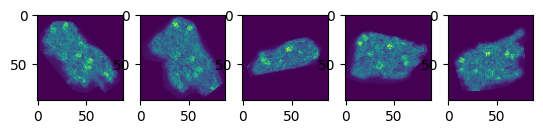

In [8]:
kidney_images_pad = size_adaption(kidney_images)
fig, axs = plt.subplots(ncols=len(kidney_images_pad))
for ax, im in zip(axs, kidney_images_pad):
    ax.imshow(kidney_images_pad[im][0, ::])
plt.show()

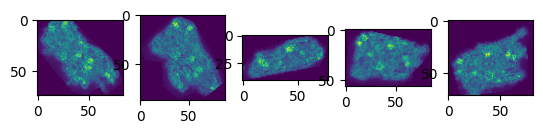

In [9]:
fig, axs = plt.subplots(ncols=len(kidney_images))
for ax, im in zip(axs, kidney_images):
    ax.imshow(kidney_images[im][0, ::])
plt.show()

## Ion overlap

In [10]:
tst = set(kidney_if['2022-12-07_02h13m50s']).intersection(set(kidney_if['2022-12-07_02h13m20s']), 
                                                          set(kidney_if['2022-12-07_02h10m45s']), 
                                                          set(kidney_if['2022-12-07_02h09m41s']), 
                                                          set(kidney_if['2022-12-07_02h08m52s']))

In [11]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 172


## Build data for training

Required: Dataset id for each image, ion id for each image

In [12]:
training_data = []
training_datasets = [] 
training_ions = []

kidney_images_pad = size_adaption(kidney_images)

for dsid, imgs in kidney_images_pad.items():
    
    training_data.append(imgs)
    training_datasets += [dsid] * imgs.shape[0]
    training_ions += kidney_if[dsid]
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

## Training

### Without dataset secific percentiles

In [44]:
model1 = DeepClustering(
                images=training_data,
                dataset_labels=training_datasets,
                ion_labels=training_ions,
                num_cluster=10,
                initial_upper=95,
                initial_lower=20,
                upper_iteration=1,
                lower_iteration=1,
                dataset_specific_percentiles=False,
                knn=True, k=10,
                lr=0.0001, batch_size=100,
                pretraining_epochs=11,
                training_epochs=16,
                cae_encoder_dim=20,
                use_gpu=True,
                random_seed=1224
            )

In [45]:
cae1, clust1 = model1.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.021278
Pretraining Epoch: 1 Loss: 0.007860
Pretraining Epoch: 2 Loss: 0.006246
Pretraining Epoch: 3 Loss: 0.005656
Pretraining Epoch: 4 Loss: 0.005232
Pretraining Epoch: 5 Loss: 0.005044
Pretraining Epoch: 6 Loss: 0.004879
Pretraining Epoch: 7 Loss: 0.004743
Pretraining Epoch: 8 Loss: 0.004613
Pretraining Epoch: 9 Loss: 0.004554
Pretraining Epoch: 10 Loss: 0.004518
Training Epoch: 0 Loss: 0.038832
Training Epoch: 1 Loss: 0.011529
Training Epoch: 2 Loss: 0.009028
Training Epoch: 3 Loss: 0.008150
Training Epoch: 4 Loss: 0.007721
Training Epoch: 5 Loss: 0.007133
Training Epoch: 6 Loss: 0.006789
Training Epoch: 7 Loss: 0.006620
Training Epoch: 8 Loss: 0.006444
Training Epoch: 9 Loss: 0.006228
Training Epoch: 10 Loss: 0.005870
Training Epoch: 11 Loss: 0.006036
Training Epoch: 12 Loss: 0.005888
Training Epoch: 13 Loss: 0.005743
Training Epoch: 14 Loss: 0.005448
Training Epoch: 15 Loss: 0.005793


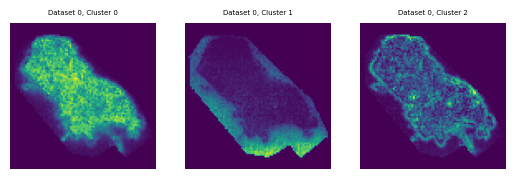

/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


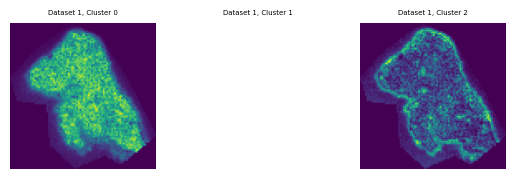

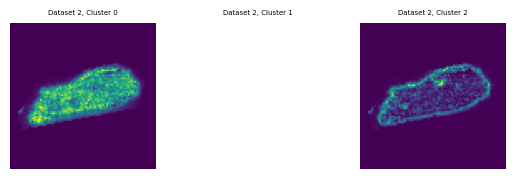

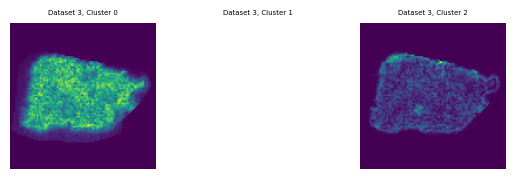

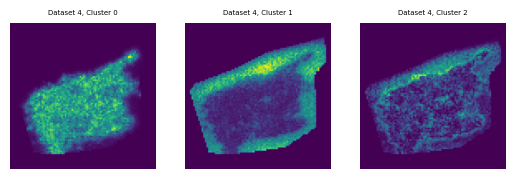

In [47]:
pred_labels1 = model1.inference(cae1, clust1)

# Loop over datasets:
ds_counter = 0
for ds in kidney_datasets:
    
    ds_imgs = model1.image_data[model1.dataset_labels==ds]
    curr_labels = pred_labels1[model1.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels1):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(pred_labels1)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1


### With dataset specific percentiles

In [51]:
model = DeepClustering(
                images=training_data,
                dataset_labels=training_datasets,
                ion_labels=training_ions,
                num_cluster=5,
                initial_upper=95,
                initial_lower=45,
                upper_iteration=1,
                lower_iteration=2,
                dataset_specific_percentiles=True,
                knn=False, k=5,
                lr=0.0001, batch_size=128,
                pretraining_epochs=11,
                training_epochs=16,
                cae_encoder_dim=20,
                use_gpu=True,
                random_seed=1224
            )

In [52]:
cae, clust = model.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.021640
Pretraining Epoch: 1 Loss: 0.007932
Pretraining Epoch: 2 Loss: 0.006236
Pretraining Epoch: 3 Loss: 0.005663
Pretraining Epoch: 4 Loss: 0.005407
Pretraining Epoch: 5 Loss: 0.005219
Pretraining Epoch: 6 Loss: 0.005006
Pretraining Epoch: 7 Loss: 0.004898
Pretraining Epoch: 8 Loss: 0.004710
Pretraining Epoch: 9 Loss: 0.004602
Pretraining Epoch: 10 Loss: 0.004570
Training Epoch: 0 Loss: 0.026314
Training Epoch: 1 Loss: 0.015350
Training Epoch: 2 Loss: 0.014035
Training Epoch: 3 Loss: 0.013365
Training Epoch: 4 Loss: 0.013010
Training Epoch: 5 Loss: 0.012673
Training Epoch: 6 Loss: 0.012723
Training Epoch: 7 Loss: 0.012717
Training Epoch: 8 Loss: 0.012492
Training Epoch: 9 Loss: 0.012461
Training Epoch: 10 Loss: 0.012047
Training Epoch: 11 Loss: 0.012289
Training Epoch: 12 Loss: 0.012189
Training Epoch: 13 Loss: 0.012466
Training Epoch: 14 Loss: 0.012281
Training Epoch: 15 Loss: 0.012210


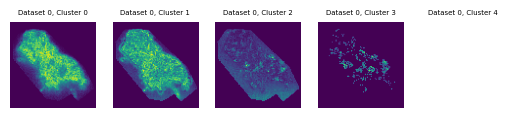

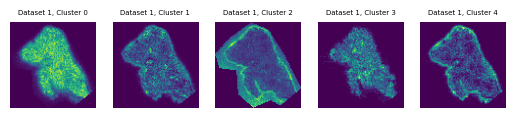

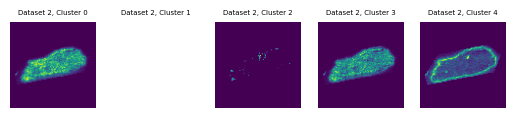

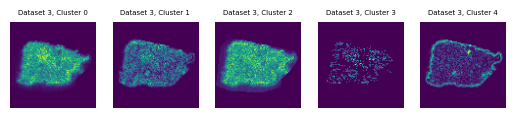

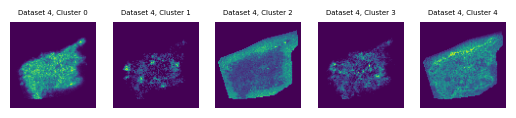

In [53]:
pred_labels = model.inference(cae, clust)

# Loop over datasets:
ds_counter = 0
for ds in kidney_datasets:
    
    ds_imgs = model.image_data[model.dataset_labels==ds]
    curr_labels = pred_labels[model.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels):
        cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
    fig, axs = plt.subplots(ncols=len(set(pred_labels)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1
